- This notebook allows to constrain the 3D morphology of galaxies from their projected images given in a galaxy survey
- Method : simulation-based inference
- Data : shape catalogue of UNIONS matched with galaxies identified with CMASS density tracers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

import corner

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CMASS density tracers (North)

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_North.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass_north = filtered_tbl.to_pandas()
cmass_north.columns

print(len(cmass_north))

618806


In [3]:
# CMASS density tracers (South)

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_South.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass_south = filtered_tbl.to_pandas()
cmass_south.columns

print(len(cmass_south))

230831


In [4]:
# Combining North and South

cmass = pd.concat([cmass_north, cmass_south], ignore_index=True)

print(len(cmass))

849637


In [5]:
# UNIONS shape catalogue

with fits.open('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_cut_struc_2024_v1.5.3.fits', memmap=True) as hdul:
    data = hdul[1].data
    selected_columns = ['RA', 'Dec','e1','e2']
    unions = pd.DataFrame({col: data[col].byteswap().newbyteorder() for col in selected_columns})

In [6]:
print(unions)

                   RA        Dec        e1        e2
0          108.370581  59.256291 -0.284876 -0.232650
1          108.643083  59.250135  0.195145  0.063940
2          107.871739  59.252632  0.159080  0.148219
3          108.441349  59.250404  0.180750 -0.529500
4          108.198100  59.250262  0.114629  0.160938
...               ...        ...       ...       ...
143256653  332.883595   3.715323  0.672961 -0.679813
143256654  332.877082   3.708592  0.472455  0.354313
143256655  332.884568   3.742759  0.183444  0.389572
143256656  332.874819   3.738361  0.324236 -0.577897
143256657  332.878778   3.722986  0.309631 -0.037124

[143256658 rows x 4 columns]


In [7]:
# Match between UNIONS and CMASS

cat_unions = SkyCoord(ra= unions['RA'], dec=unions['Dec'],unit='deg')
cat_cmass = SkyCoord(ra=cmass['RA'] , dec=cmass['DEC'] , unit='deg')
idx, d2d, d3d = match_coordinates_sky(cat_unions, cat_cmass)

unions_cmass_cross = unions.loc[d2d.value < 0.00028]

print(len(unions_cmass_cross))

nb_unions_cmass = len(unions_cmass_cross)

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

210440


In [8]:
# Somes functions required for further work

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

In [9]:
# DATA : summary statistics P(e) of CMASS-UNIONS

a = np.zeros(len(unions_cmass_cross))
b = np.zeros(len(unions_cmass_cross))
theta = np.zeros(len(unions_cmass_cross))
axis_ratio_cmass = np.zeros(len(unions_cmass_cross))
e1cmass = np.zeros(len(unions_cmass_cross))
e2cmass = np.zeros(len(unions_cmass_cross))
ecmass = np.zeros(len(unions_cmass_cross))

e1_values = unions_cmass_cross['e1'][unions_cmass_index]
e2_values = unions_cmass_cross['e2'][unions_cmass_index]

a, b = np.vectorize(a_b)(e1_values, e2_values)
axis_ratio_cmass = a / b

theta = np.vectorize(get_galaxy_orientation_angle)(e1_values, e2_values)
e1cmass, e2cmass = np.vectorize(e_complex)(a, b, theta)

ecmass = np.vectorize(abs_e)(e1cmass, e2cmass)

In [12]:
# SIMULATION : function that returns the normalized projected ellipticities of the nb_unions_cmass 3D galaxies of the 
# simulated survey. The projection is done along the line-of-sight (LOS, direction 'y'). 

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf


def simulation(theta, # The parameters of the 3D model (mu_B, mu_C, sigma_B, sigma_C, r)
               nb_galaxies=nb_unions_cmass, # The number of matched galaxies
               p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
               A=1, # The major axis of the galaxies, fixed to 1 in the analysis
               e_bins=np.linspace(0,1,50) # The number of bins for the histogram of e_counts (output)
               ):

    mu_B, mu_C, sigma_B, sigma_C, r = theta # (mu_B, mu_C, sigma_B, sigma_C, r)
    
    # Random gaussian draw to obtain the axis lengths B,C
    BC2 = np.empty((0, 2))
    while len(BC2) < nb_galaxies:
        BC = np.random.multivariate_normal(mean=[mu_B, mu_C], cov=[[sigma_B**2, r*sigma_B*sigma_C], [r*sigma_B*sigma_C, sigma_C**2]], size=nb_galaxies)
    
    # Priors : B/A<1 ; C/A<1 ; C<B ; C>0 ; B>0
        mask = (BC[:,0]/A<=1) & (BC[:,1]/ A<=1) & (BC[:,0] >= BC[:,1]) & (BC[:,0]>0) & (BC[:,1]>0)
        BC_valid = BC[mask]

        BC2 = np.concatenate((BC2, BC_valid), axis=0)
    
    BC2 = BC2[:nb_galaxies]
    B, C = BC2[:, 0], BC2[:, 1]
    

    A=np.ones(nb_galaxies)


    # Random orientation angles by drawing quaternions (to have orientations uniformly distributed in the sky)
    rand_quat = np.random.randn(nb_galaxies,4) ; rand_quat /= np.linalg.norm(rand_quat, axis=1, keepdims=True)
    rotation = Rotation.from_quat(rand_quat) ; euler_angles = rotation.as_euler('ZYX', degrees=True)
    euler_angles_rad = euler_angles*np.pi/180
    psi = euler_angles_rad[:,0]; theta = euler_angles_rad[:,1] ; phi = euler_angles_rad[:,2]
    

    # Rotation matrix that relates the eigenvectors (X,Y,Z) of the galaxies to a frame of reference (x,y,z)
    D = np.zeros((nb_galaxies, 3, 3))

    D[:, 0, 0] = np.cos(theta) * np.cos(psi)
    D[:, 0, 1] = -np.cos(phi) * np.sin(psi) + np.sin(phi) * np.sin(theta) * np.cos(psi)
    D[:, 0, 2] = np.sin(phi) * np.sin(psi) + np.cos(phi) * np.sin(theta) * np.cos(psi)

    D[:, 1, 0] = np.cos(theta) * np.sin(psi)
    D[:, 1, 1] = np.cos(phi) * np.cos(psi) + np.sin(phi) * np.sin(theta) * np.sin(psi)
    D[:, 1, 2] = -np.sin(phi) * np.cos(psi) + np.cos(phi) * np.sin(theta) * np.sin(psi)

    D[:, 2, 0] = -np.sin(theta)
    D[:, 2, 1] = np.sin(phi) * np.cos(theta)
    D[:, 2, 2] = np.cos(phi) * np.cos(theta)

    
    evc0 = np.asarray([[1,0,0],[0,1,0],[0,0,1]]) # Frame of reference (x,y,z)
    evcl = np.einsum('ijk,kl->ijl', D, evc0) # Eigenvectors (X,Y,Z)


    #Eigenvalues (Maj,Mid,Min)
    evls = np.array([A,B,C])**2 ; evls=np.transpose(evls)


    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))

    # Projected ellipticity
    def e_complex(a,b,r):
        abs_e = (1-(b/a)) / (1+(b/a))
        e1 = abs_e*np.cos(2*r)
        e2 = abs_e*np.sin(2*r)
        return e1, e2

    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)

    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    
    return e_counts/nb_galaxies

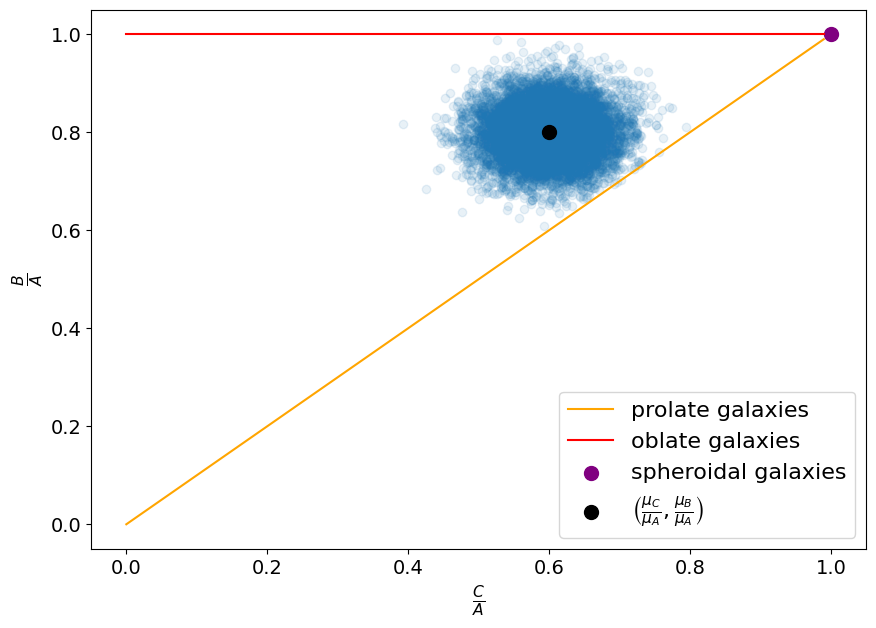

In [13]:
# Visualisation of a population of ellipsoidal galaxies with axis lengths B,C (convention A=1>B>C)

A=1 ; nb_galaxies = 10000

# Model = {mu_B, mu_C, sigma_B, sigma_C}
mu_B=0.8; mu_C=0.6; sigma_B=0.05; sigma_C=0.05; r=0.01

BC = np.random.multivariate_normal(mean=[mu_B,mu_C],cov=[[sigma_B**2,r*sigma_B*sigma_C],[r*sigma_B*sigma_C,sigma_C**2]],size=nb_galaxies)


# remove B/A>1, C/A>1, C>B, B<0, C<0
# B => BC[0,0] ; C => BC[0,1]
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC2 = BC[mask]


plt.figure( figsize = (10,7) )
plt.scatter(BC2[:,1]/A,BC2[:,0]/A,alpha=0.1)
plt.xlabel(r"$\frac{C}{A}$",fontsize=16) ; plt.ylabel(r"$\frac{B}{A}$",fontsize=16)
#plt.title("(A>B>C)",fontsize=16)

x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([1], [1], color='purple', label='spheroidal galaxies', s=100)
plt.scatter([mu_C],[mu_B],color='black',label=r'$\left(\frac{\mu_C}{\mu_A},\frac{\mu_B}{\mu_A}\right)$', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("Population.pdf")

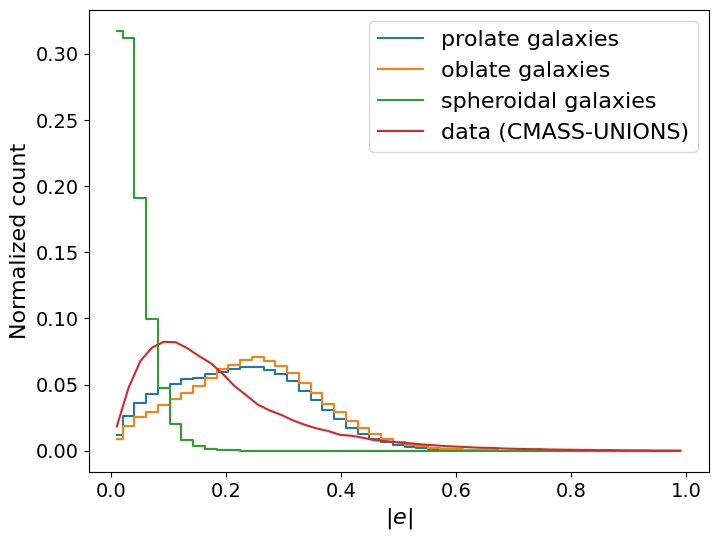

In [ ]:
# View of simulations for differents shapes of 3D galaxies, and superposition with the data

x_estimated1 = simulation([0.5, 0.5, 0.1, 0.1, 0.01])
x_estimated2 = simulation([1,   0.5, 0.1, 0.1, 0.01])
x_estimated3 = simulation([1,   1,   0.1, 0.1, 0.0])

e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

plt.figure(figsize=(8,6))
plt.plot(e_cents,x_estimated1,drawstyle='steps-mid',label='prolate galaxies')
plt.plot(e_cents,x_estimated2,drawstyle='steps-mid',label='oblate galaxies')
plt.plot(e_cents,x_estimated3,drawstyle='steps-mid',label='spheroidal galaxies')
plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("P(e).png")

In [ ]:
# PRIOR : 

class CustomPrior(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define uniform priors for the parameters (mu_B, mu_C, sigma_B, sigma_C, r)
        self.prior_uniform = BoxUniform(
            low=torch.tensor( [0.0,  0., 0, 0, -0.8]), 
            high=torch.tensor([1.0, 1., 1, 1, 0.8])
        )
    
    def log_prob(self, x):
        # Check the constraint mu_B > mu_C
        muB_minus_muC = x[..., 1] - x[..., 0]  # assuming mu_B is at index 0 and mu_C at index 1
        mask = ( muB_minus_muC > 0 )
        return torch.where(mask, self.prior_uniform.log_prob(x), torch.tensor(-float('inf')))
    
    def sample(self, sample_shape=torch.Size()):
        if len(sample_shape) == 0:
            sample_shape = torch.Size([1])  # Default to a single sample if sample_shape is empty
            
        samples = []
        while len(samples) < sample_shape[0]:
            sample = self.prior_uniform.sample((1,))
            if ( -sample[..., 0] + sample[..., 1]).lt(0):  # this checks if it is less than zero, so I switched it around
                samples.append(sample)
                
        return torch.cat(samples, dim=0)

# Instantiate the custom prior
prior = CustomPrior()

In [59]:
# Neural posterior estimation

posterior = infer(simulation, prior, method = 'NPE', num_simulations = 60000, num_workers = 10)

100%|██████████| 60000/60000 [1:01:48<00:00, 16.18it/s]


 Neural network successfully converged after 256 epochs.

In [ ]:
# DATA

e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts,_ = np.histogram(ecmass, bins = e_bins) 

e_counts_data = [e_data_counts] ; e_counts_data=np.array(e_counts_data)
print(e_counts_data.shape)

x_obs = e_counts_data/nb_unions_cmass

(1, 49)


In [61]:
samples = posterior.sample((30000,), x=x_obs)
samples = samples.numpy()

Drawing 30000 posterior samples: 100%|██████████| 30000/30000 [00:00<00:00, 65003.98it/s]


/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_59595/3726092354.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


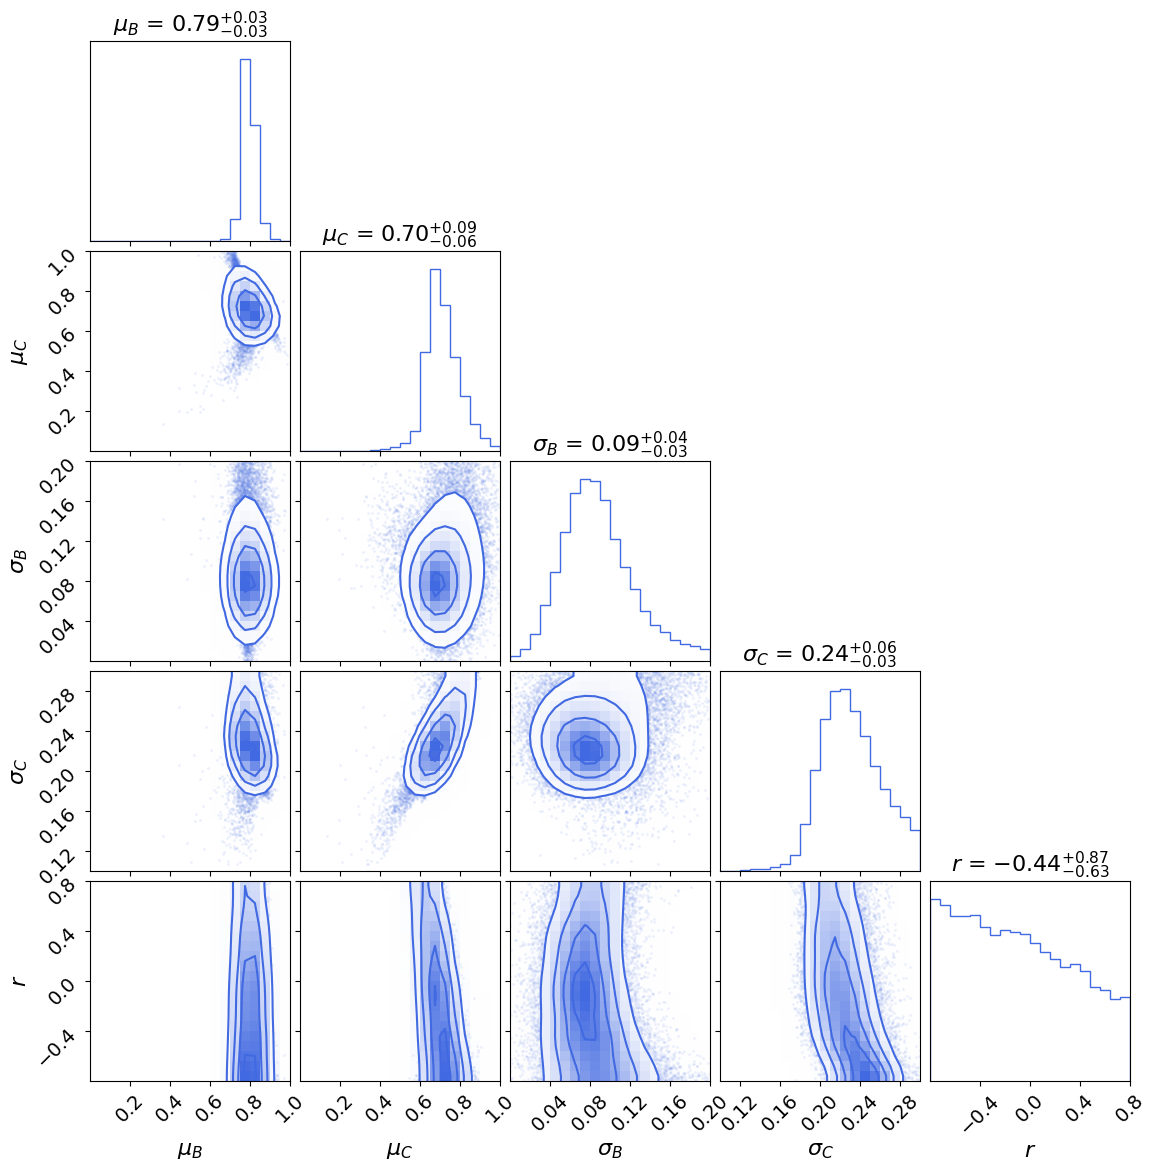

In [ ]:
# Plot of the final contours

labels = [r"$\mu_B$", r"$\mu_C$", r"$\sigma_B$", r"$\sigma_C$", r"$r$"]
ranges = [[0, 1], [0, 1], [0, 0.2], [0.1, 0.3], [-0.8, 0.8]]


fig = corner.corner(
    samples, 
    labels=labels, 
    range=ranges, 
    show_titles=True, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  # Lissage des contours pour un rendu plus propre
    plot_density=True,  # Ajout des contours
    plot_contours=True,  # Tracer les contours de densité
    color="royalblue"
)

for ax in fig.axes:
    ax.tick_params(labelsize=14)

fig.show()

plt.savefig("3D_constraints.pdf")

0.79488903 0.71437025 0.094508626 0.2521102 -0.35588777


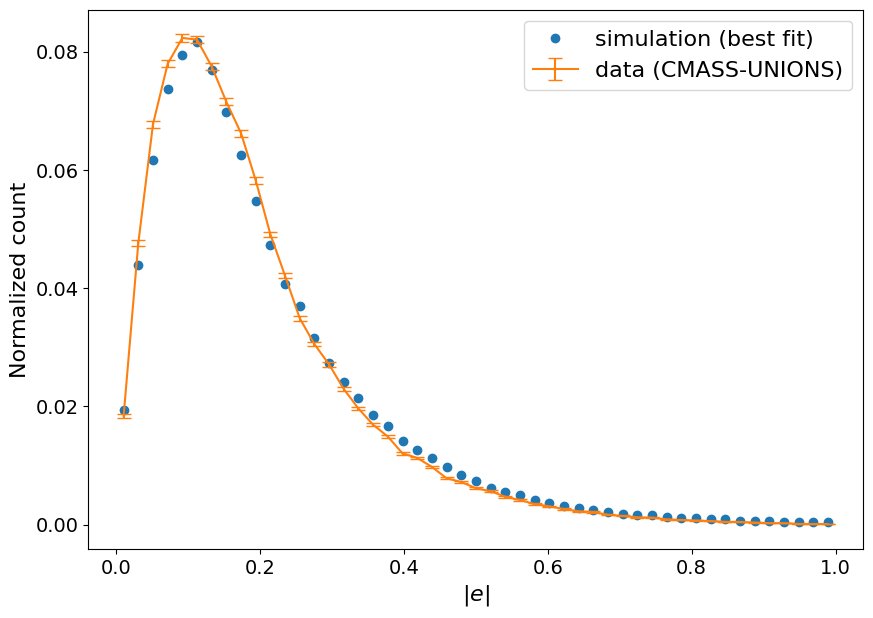

In [81]:
# Best fit obtained after having performed the simulations

theta_estimated=np.mean(samples, axis=0)

mu_B, mu_C, sigma_B, sigma_C, r = theta_estimated[0], theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]


x_estimated = simulation([mu_B, mu_C, sigma_B, sigma_C, r])


plt.figure( figsize = (10,7) )
plt.plot(e_cents,x_estimated,drawstyle='steps-mid', marker='o', linestyle='',label='simulation (best fit)')
plt.errorbar(e_cents, e_data_counts/nb_unions_cmass, yerr=np.sqrt(e_data_counts) / nb_unions_cmass, label="data (CMASS-UNIONS)", capsize=5)
#plt.plot(e_cents,e_data_counts/nb_unions_cmass,label="data (CMASS-UNIONS)")
plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("best_fit.pdf")

#mu_B, mu_C, sigma_B, sigma_C, r = theta_estimated[0], theta_estimated[0]-theta_estimated[1], theta_estimated[2], theta_estimated[3], theta_estimated[4]
print(mu_B, mu_C, sigma_B, sigma_C, r)

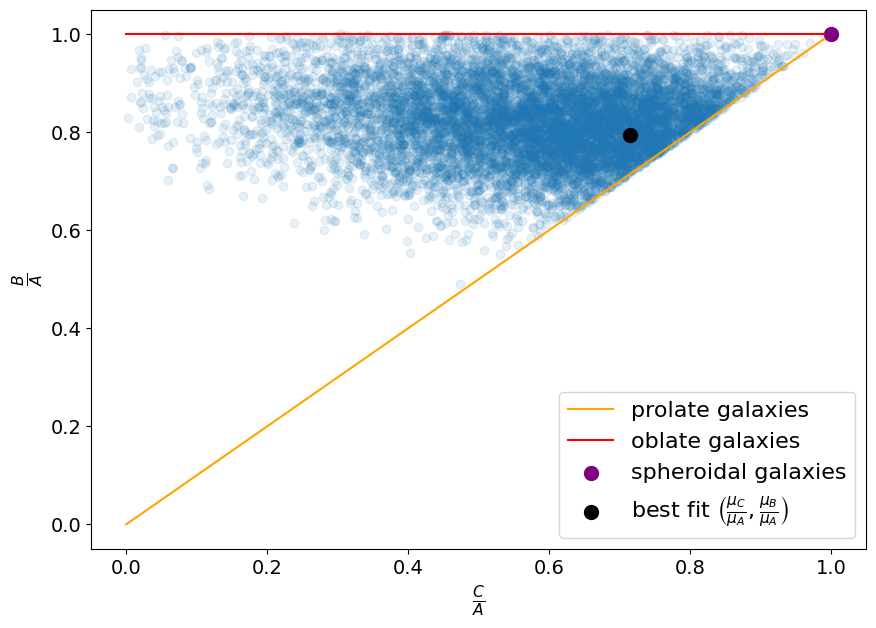

In [82]:
# Visualisation of the 3D population of ellipsoidal galaxies with axis lengths B,C (convention A=1>B>C)

nb_galaxies=nb_unions_cmass; A=1

BC = np.random.multivariate_normal(mean=[mu_B,mu_C],cov=[[sigma_B**2,r*sigma_B*sigma_C],[r*sigma_B*sigma_C,sigma_C**2]],size=nb_galaxies)

# remove B/A>1, C/A>1, C>B, B<0, C<0
mask = (BC[:, 0] / A <= 1) & (BC[:, 1] / A <= 1) & (BC[:, 0] >= BC[:, 1]) & (BC[:, 0] > 0) & (BC[:, 1] > 0)
BC2 = BC[mask]

plt.figure( figsize = (10,7) )
plt.scatter(BC2[:10000,1]/A,BC2[:10000,0]/A,alpha=0.1)
plt.xlabel(r"$\frac{C}{A}$",fontsize=16) ; plt.ylabel(r"$\frac{B}{A}$",fontsize=16)

x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='orange',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([1], [1], color='purple', label='spheroidal galaxies', s=100)
plt.scatter([mu_C],[mu_B],color='black',label=r'best fit $\left(\frac{\mu_C}{\mu_A},\frac{\mu_B}{\mu_A}\right)$', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("3D_Population.pdf")

Conclusion : CMASS-UNIONS galaxies are more prolate !